In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader


In [84]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (0,1)
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

In [18]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
recessions =  DataReader('USREC', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-12)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('M').last()
print(df.shape)
df.head()

(11070, 126)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,in a recession,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962,0.0,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000,0.0,0.0
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0


In [19]:
test_split=round(len(df)*0.20)
df_for_training=df[:"2004"]
df_for_testing=df["2004":"2021"]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

df_for_training shape:  (5292, 126)
df_for_testing shape:  (5698, 126)


In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
# df_for_training_scaled[np.isnan(df_for_training_scaled)] = -1
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))
# df_for_testing_scaled[np.isnan(df_for_testing_scaled)] = -1


In [23]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)



In [24]:
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)

Epoch 1/100
148/148 [==============================] - 12s 35ms/step - loss: 0.0918 - val_loss: 0.0083
Epoch 2/100
148/148 [==============================] - 4s 24ms/step - loss: 0.0837 - val_loss: 0.0030
Epoch 3/100
148/148 [==============================] - 4s 26ms/step - loss: 0.0781 - val_loss: 0.0016
Epoch 4/100
148/148 [==============================] - 4s 26ms/step - loss: 0.0755 - val_loss: 0.0022
Epoch 5/100
148/148 [==============================] - 4s 26ms/step - loss: 0.0724 - val_loss: 9.8433e-04
Epoch 6/100
148/148 [==============================] - 4s 24ms/step - loss: 0.0679 - val_loss: 2.2676e-04
Epoch 7/100
148/148 [==============================] - 4s 26ms/step - loss: 0.0680 - val_loss: 2.4277e-04
Epoch 8/100
148/148 [==============================] - 4s 27ms/step - loss: 0.0659 - val_loss: 8.0549e-05
Epoch 9/100
148/148 [==============================] - 4s 27ms/step - loss: 0.0673 - val_loss: 8.3642e-05
Epoch 10/100
148/148 [==============================] - 4s 27

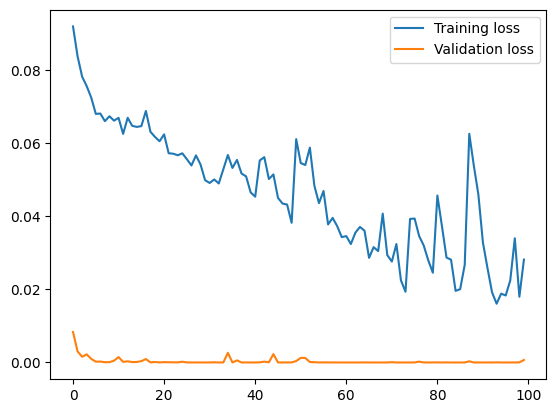

In [11]:
model = Sequential()
model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(n_forecast,activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [12]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
print("\nMax and min",prediction.max(),prediction.min())


178/178 [==============================] - 5s 9ms/step
prediction
 [[0.01474847]
 [0.01398949]
 [0.01385142]
 ...
 [0.3989679 ]
 [0.44392583]
 [0.4915863 ]]

Prediction Shape- (5668, 1)

Max and min 0.99816895 0.00011042223


In [13]:
prediction_train=model.predict(trainX)
print("prediction_train\n", prediction_train)
print("\nPrediction Shape-",prediction_train.shape)

165/165 [==============================] - 2s 10ms/step
prediction_train
 [[0.06079741]
 [0.06159874]
 [0.05714739]
 ...
 [0.056699  ]
 [0.05755872]
 [0.05723698]]

Prediction Shape- (5262, 1)


(<Figure size 3000x1800 with 1 Axes>, <Axes: >)

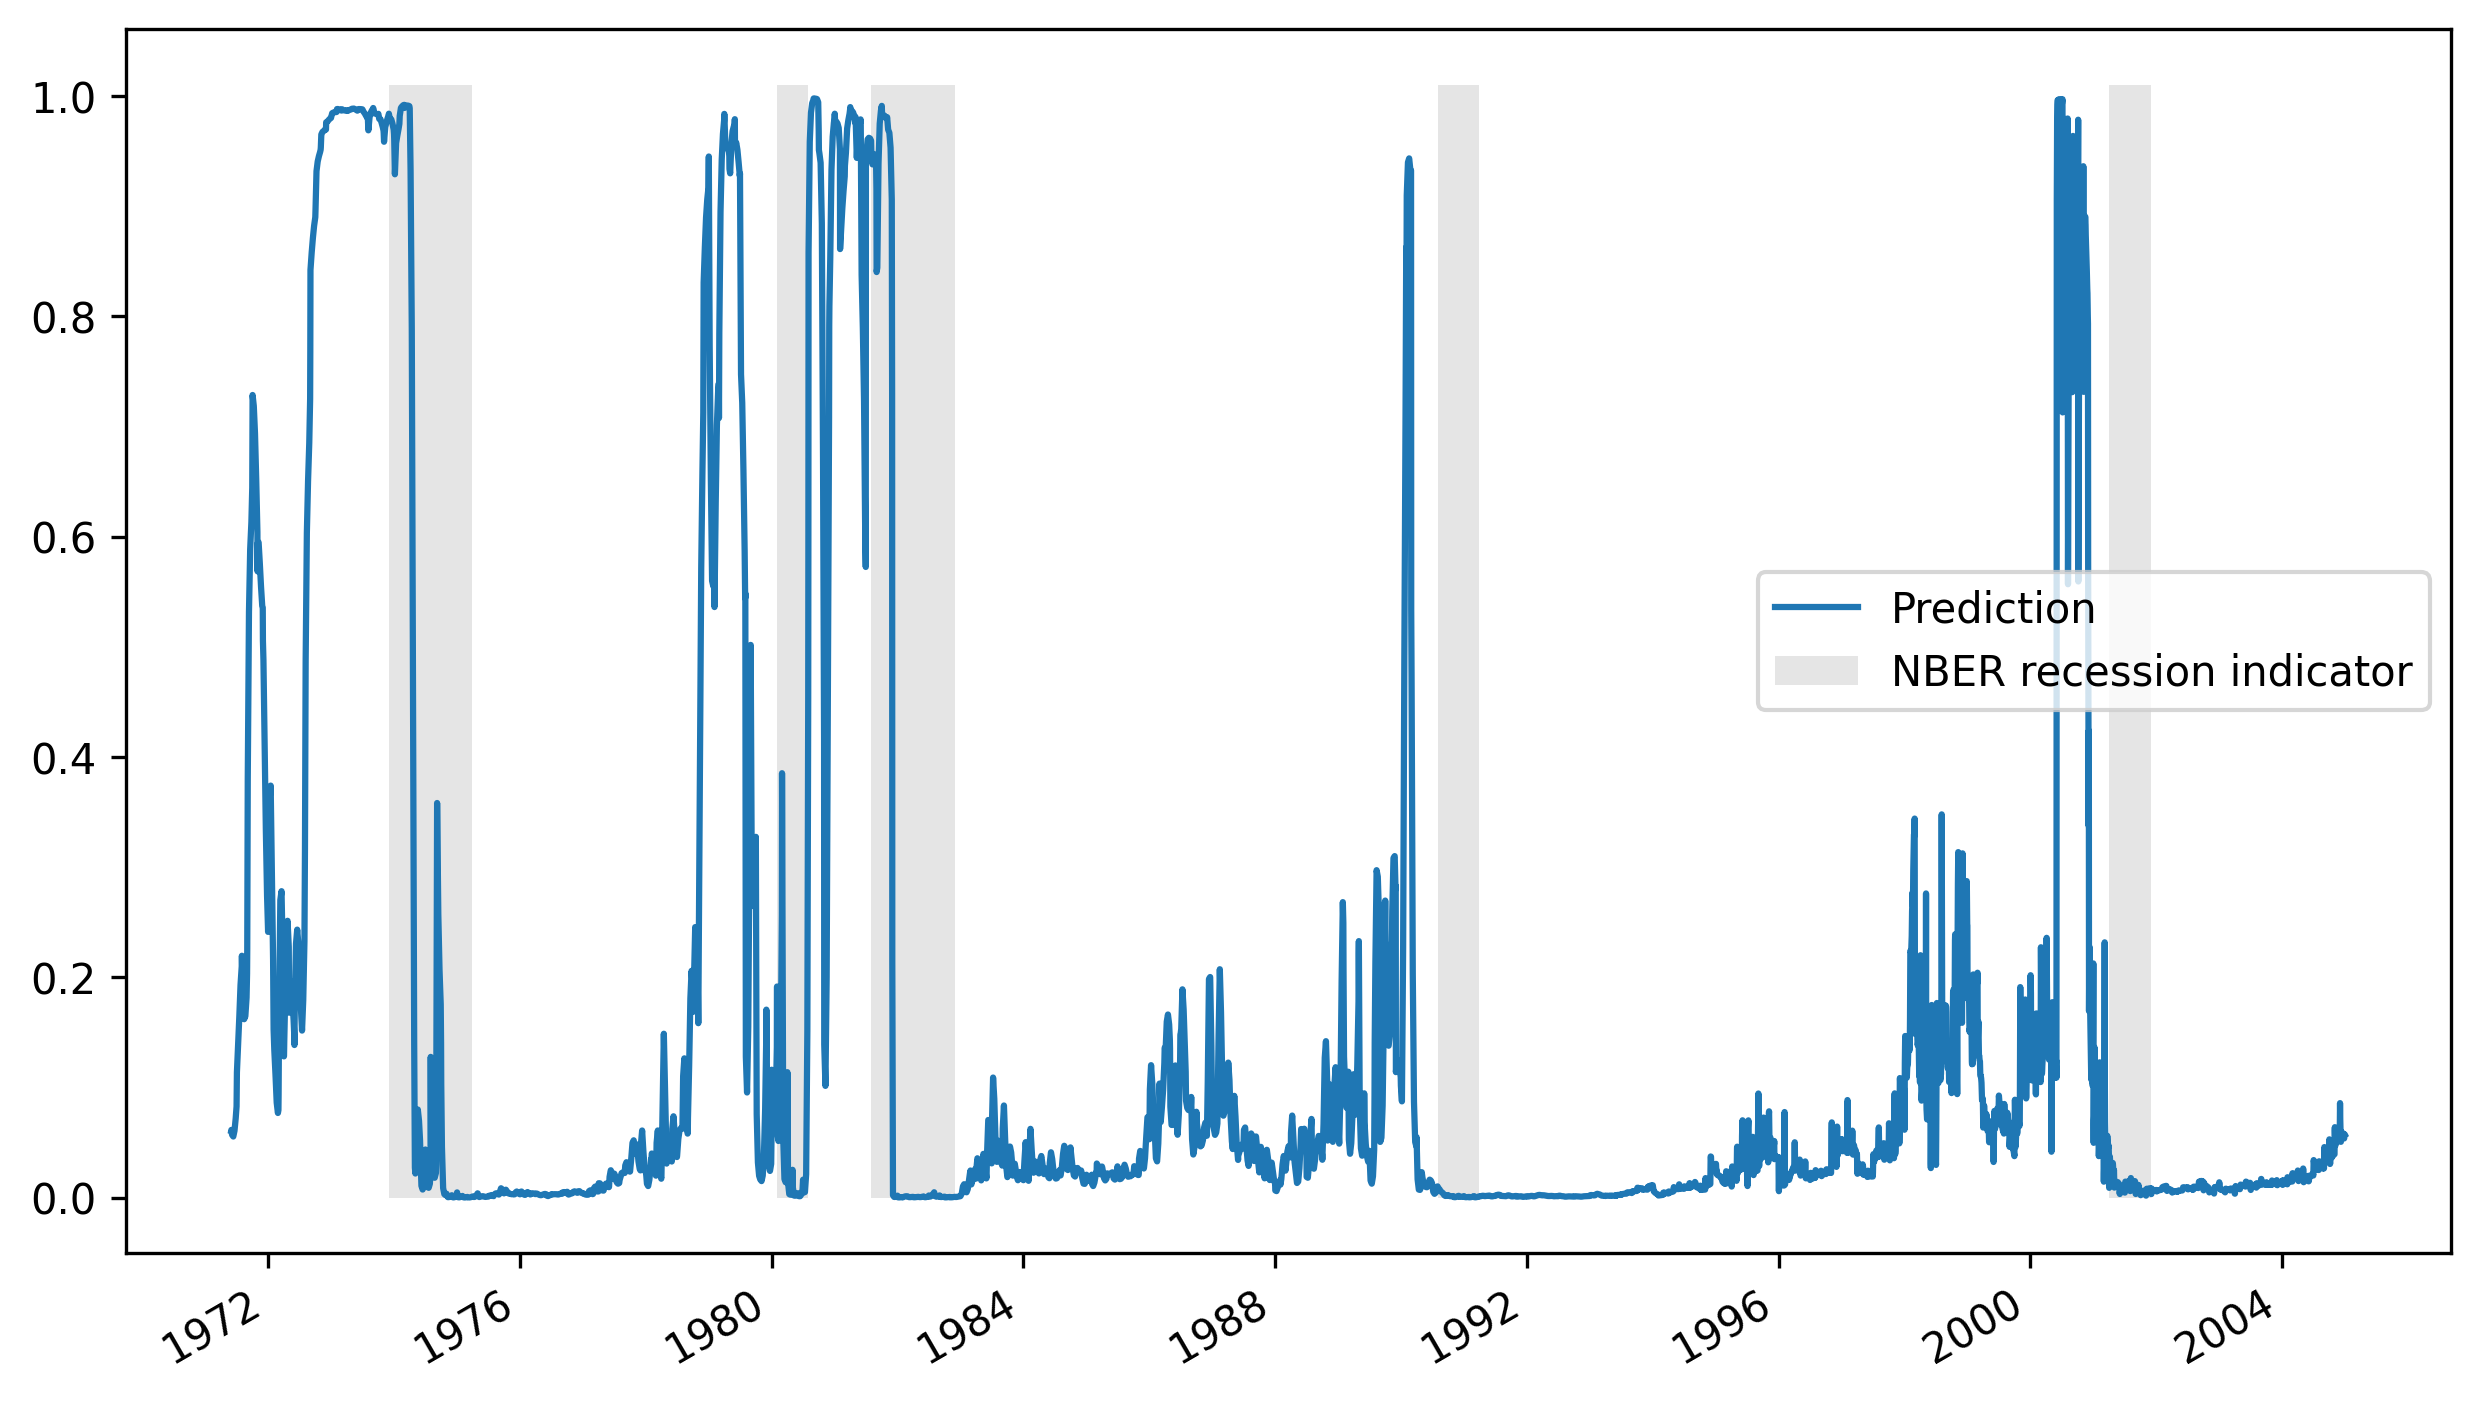

In [20]:
plot(prediction_train,df_for_training.iloc[-prediction_train.shape[0]:,-2])

(<Figure size 3000x1800 with 1 Axes>, <Axes: >)

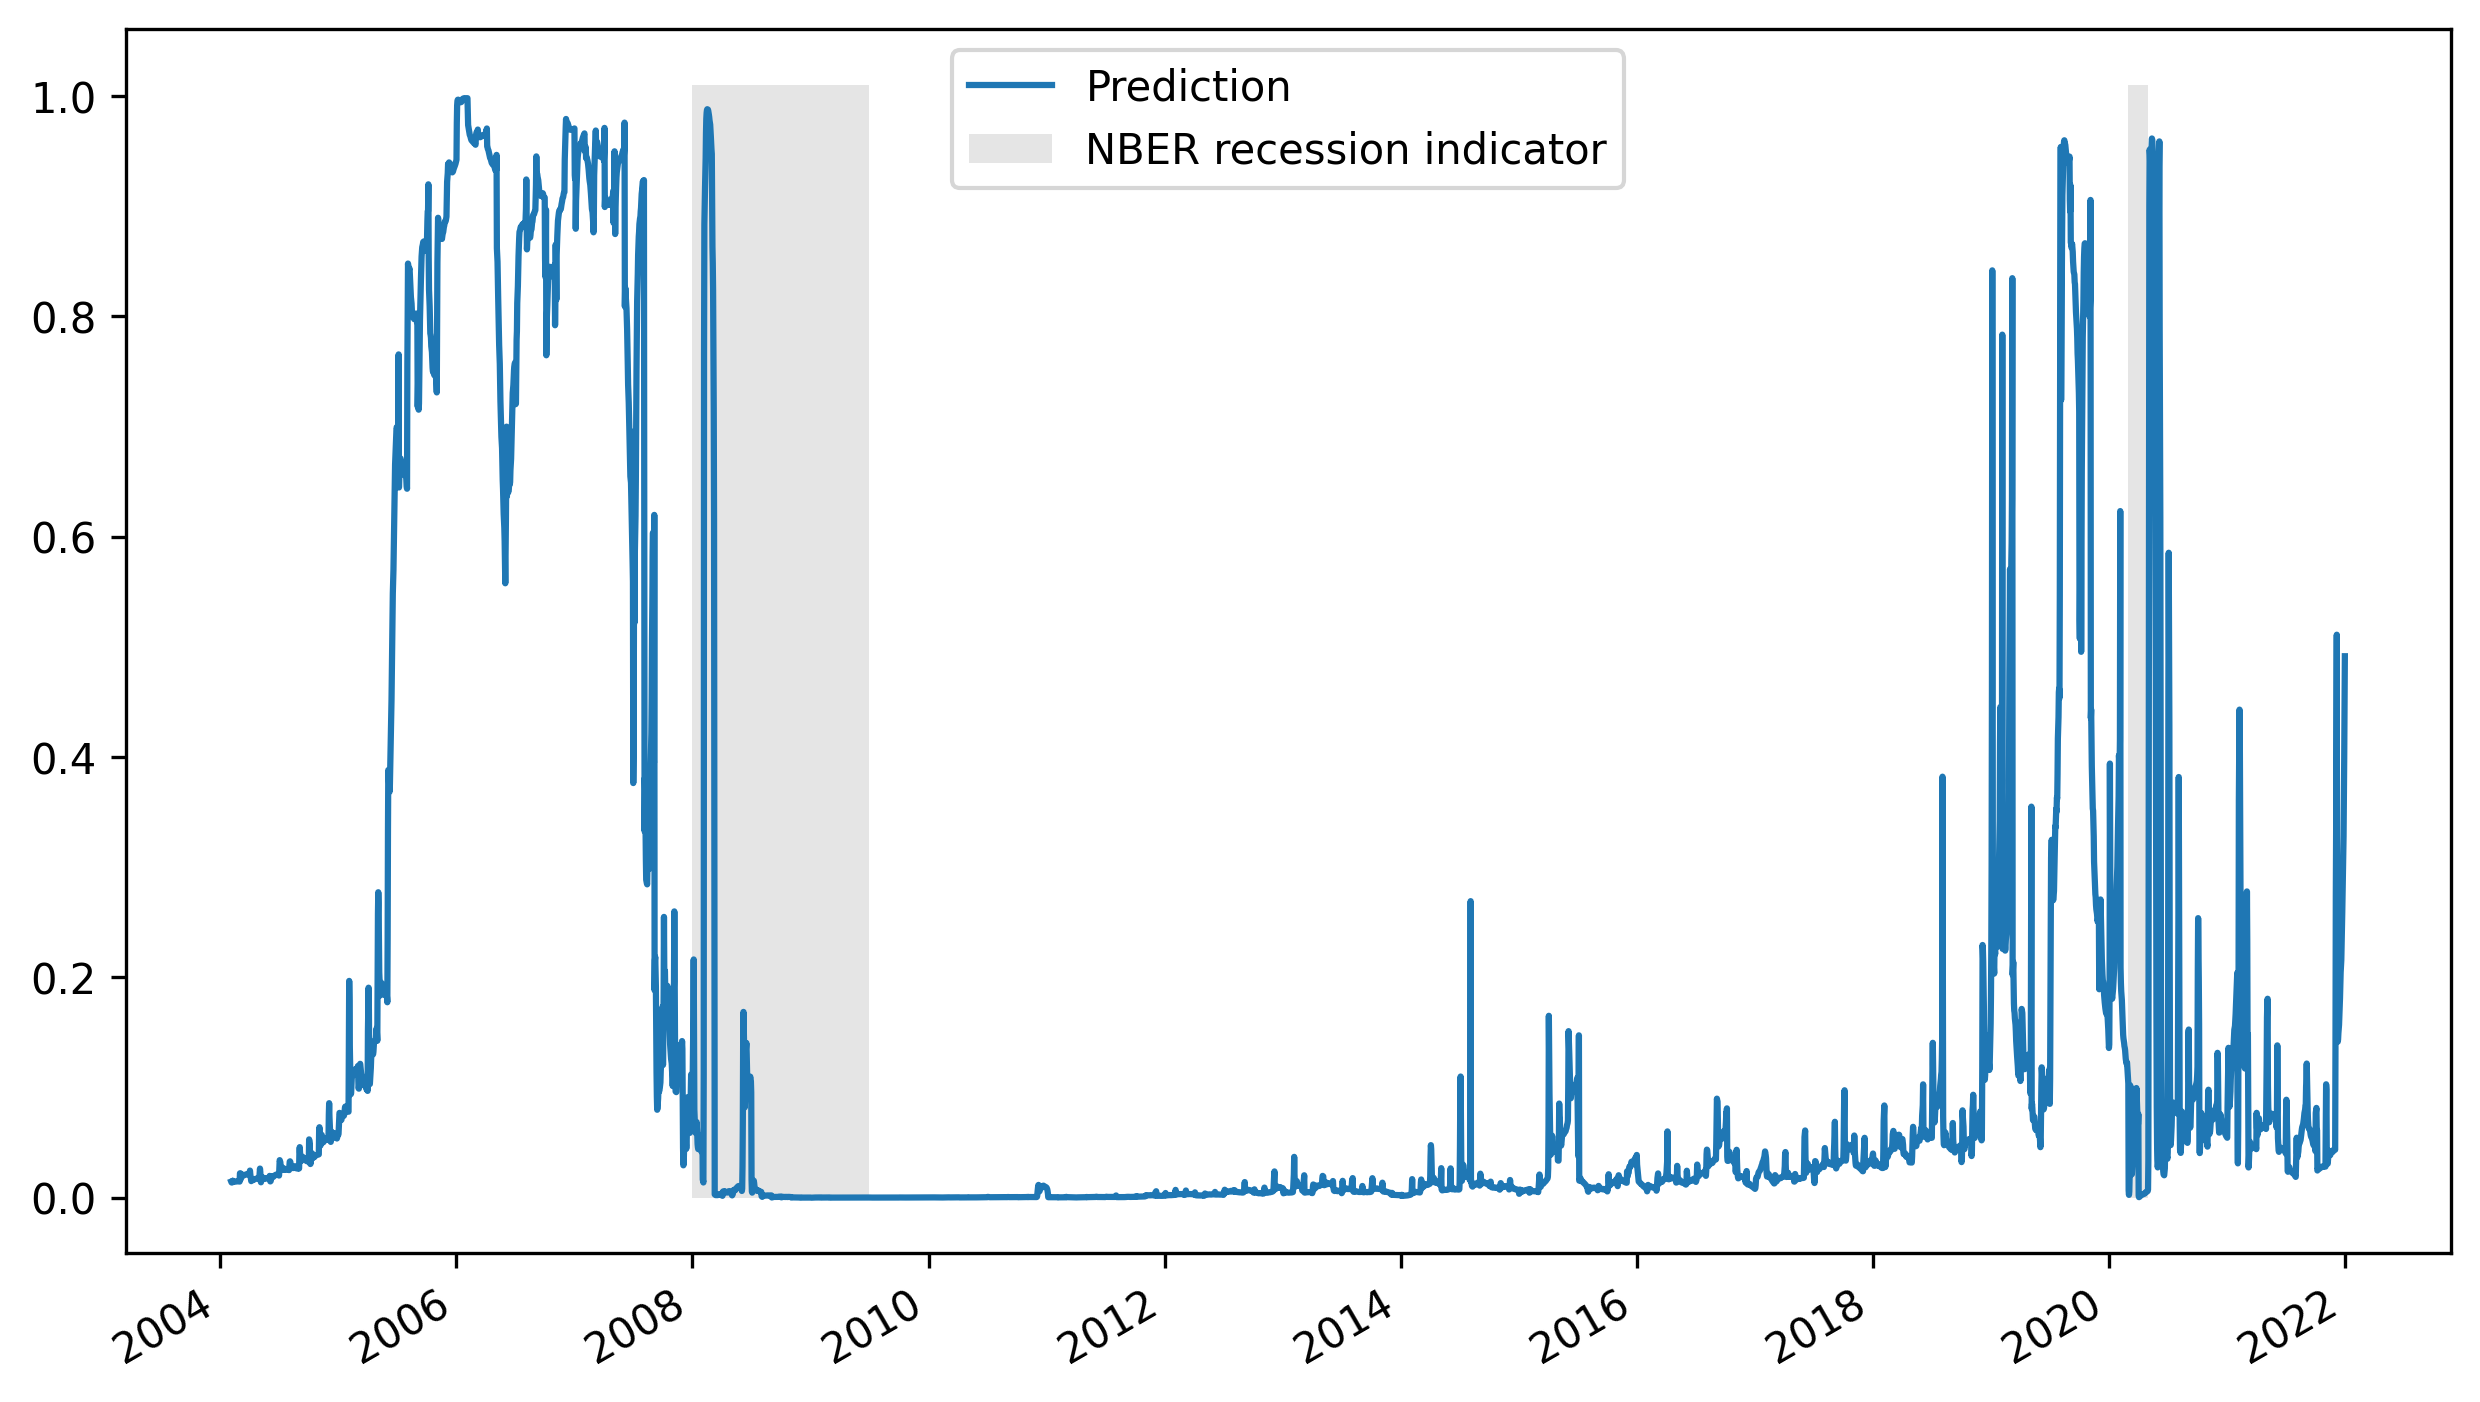

In [21]:
plot(prediction,df_for_testing.iloc[-prediction.shape[0]:,-2])

# with recessions 

In [69]:
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(n_forecast))

model.compile(optimizer='adam', loss=lambda labels, logits: tf.nn.weighted_cross_entropy_with_logits(labels, logits, 0.2))
# fit the model
history = model.fit(trainX, trainY, epochs=600, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/600
148/148 [==============================] - 13s 47ms/step - loss: 0.1040 - val_loss: 0.0214
Epoch 2/600
148/148 [==============================] - 5s 37ms/step - loss: 0.0973 - val_loss: 0.0168
Epoch 3/600
148/148 [==============================] - 5s 31ms/step - loss: 0.0982 - val_loss: 0.0283
Epoch 4/600
148/148 [==============================] - 4s 30ms/step - loss: 0.0968 - val_loss: 0.0206
Epoch 5/600
148/148 [==============================] - 5s 34ms/step - loss: 0.0951 - val_loss: 0.0099
Epoch 6/600
148/148 [==============================] - 5s 35ms/step - loss: 0.0896 - val_loss: 0.0151
Epoch 7/600
148/148 [==============================] - 4s 29ms/step - loss: 0.0794 - val_loss: 0.0033
Epoch 8/600
148/148 [==============================] - 4s 30ms/step - loss: 0.0762 - val_loss: 0.0085
Epoch 9/600
148/148 [==============================] - 4s 28ms/step - loss: 0.0730 - val_loss: 0.0029
Epoch 10/600
148/148 [==============================] - 4s 29ms/step - loss: 0.07

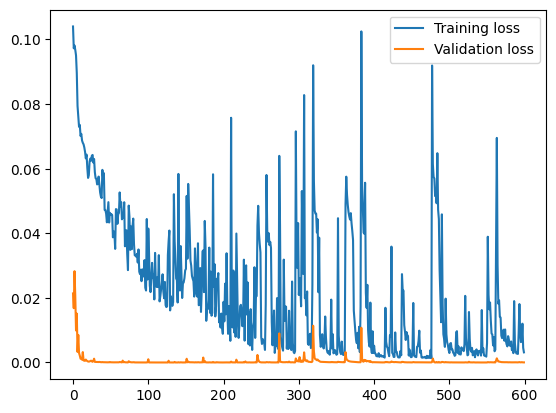

In [70]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [71]:
prediction=model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)
print("\nMax and min",prediction.max(),prediction.min())


178/178 [==============================] - 4s 14ms/step
prediction
 [[-10.180485 ]
 [-10.337738 ]
 [-10.463629 ]
 ...
 [  7.6193967]
 [  3.489602 ]
 [  6.893459 ]]

Prediction Shape- (5668, 1)

Max and min 12.209716 -14.439409


In [72]:

prediction_train=model.predict(trainX)
print("prediction_train\n", prediction_train)
print("\nPrediction Shape-",prediction_train.shape)


165/165 [==============================] - 2s 15ms/step
prediction_train
 [[-8.533815 ]
 [-8.414594 ]
 [-6.8640494]
 ...
 [-9.529865 ]
 [-9.506376 ]
 [-9.527403 ]]

Prediction Shape- (5262, 1)


In [73]:
def normalize(S):
    return (S-S.min())/(S.max()-S.min())

In [74]:
df_for_training.iloc[-prediction_train.shape[0]:,-2]

1971-05-31    0.0
1971-06-01    0.0
1971-06-05    0.0
1971-06-12    0.0
1971-06-19    0.0
             ... 
2004-12-27    0.0
2004-12-28    0.0
2004-12-29    0.0
2004-12-30    0.0
2004-12-31    0.0
Name: in a recession, Length: 5262, dtype: float64

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

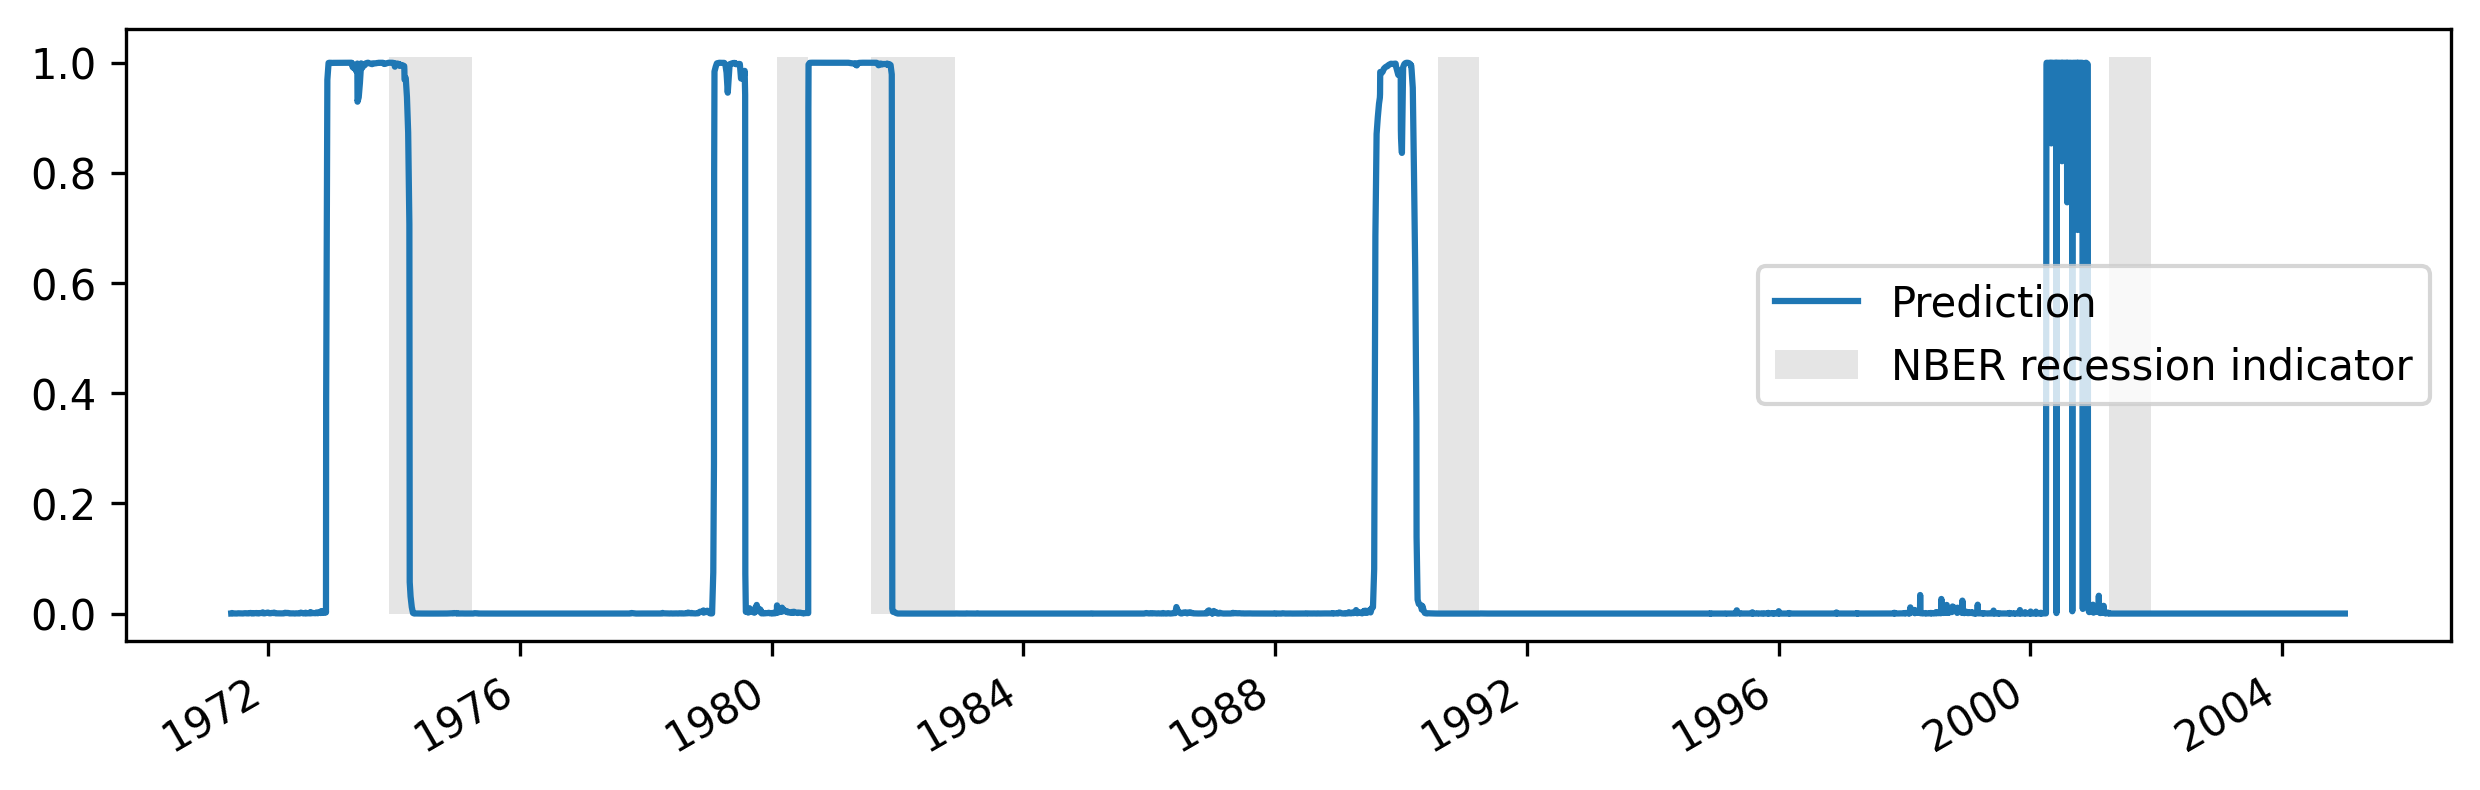

In [85]:
trainResults= pd.DataFrame()
trainResults['Actual']=df_for_training.iloc[-prediction_train.shape[0]:,-2]
trainResults['Pred']=prediction_train
plot(tf.math.sigmoid(prediction_train),df_for_training.iloc[-prediction_train.shape[0]:,-2])


In [77]:
testResults['Pred'].rolling(10).mean()

2004-02-04         NaN
2004-02-05         NaN
2004-02-06         NaN
2004-02-07         NaN
2004-02-09         NaN
                ...   
2021-12-27    8.964398
2021-12-28    8.873926
2021-12-29    8.701950
2021-12-30    8.114992
2021-12-31    7.870588
Name: Pred, Length: 5668, dtype: float64

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

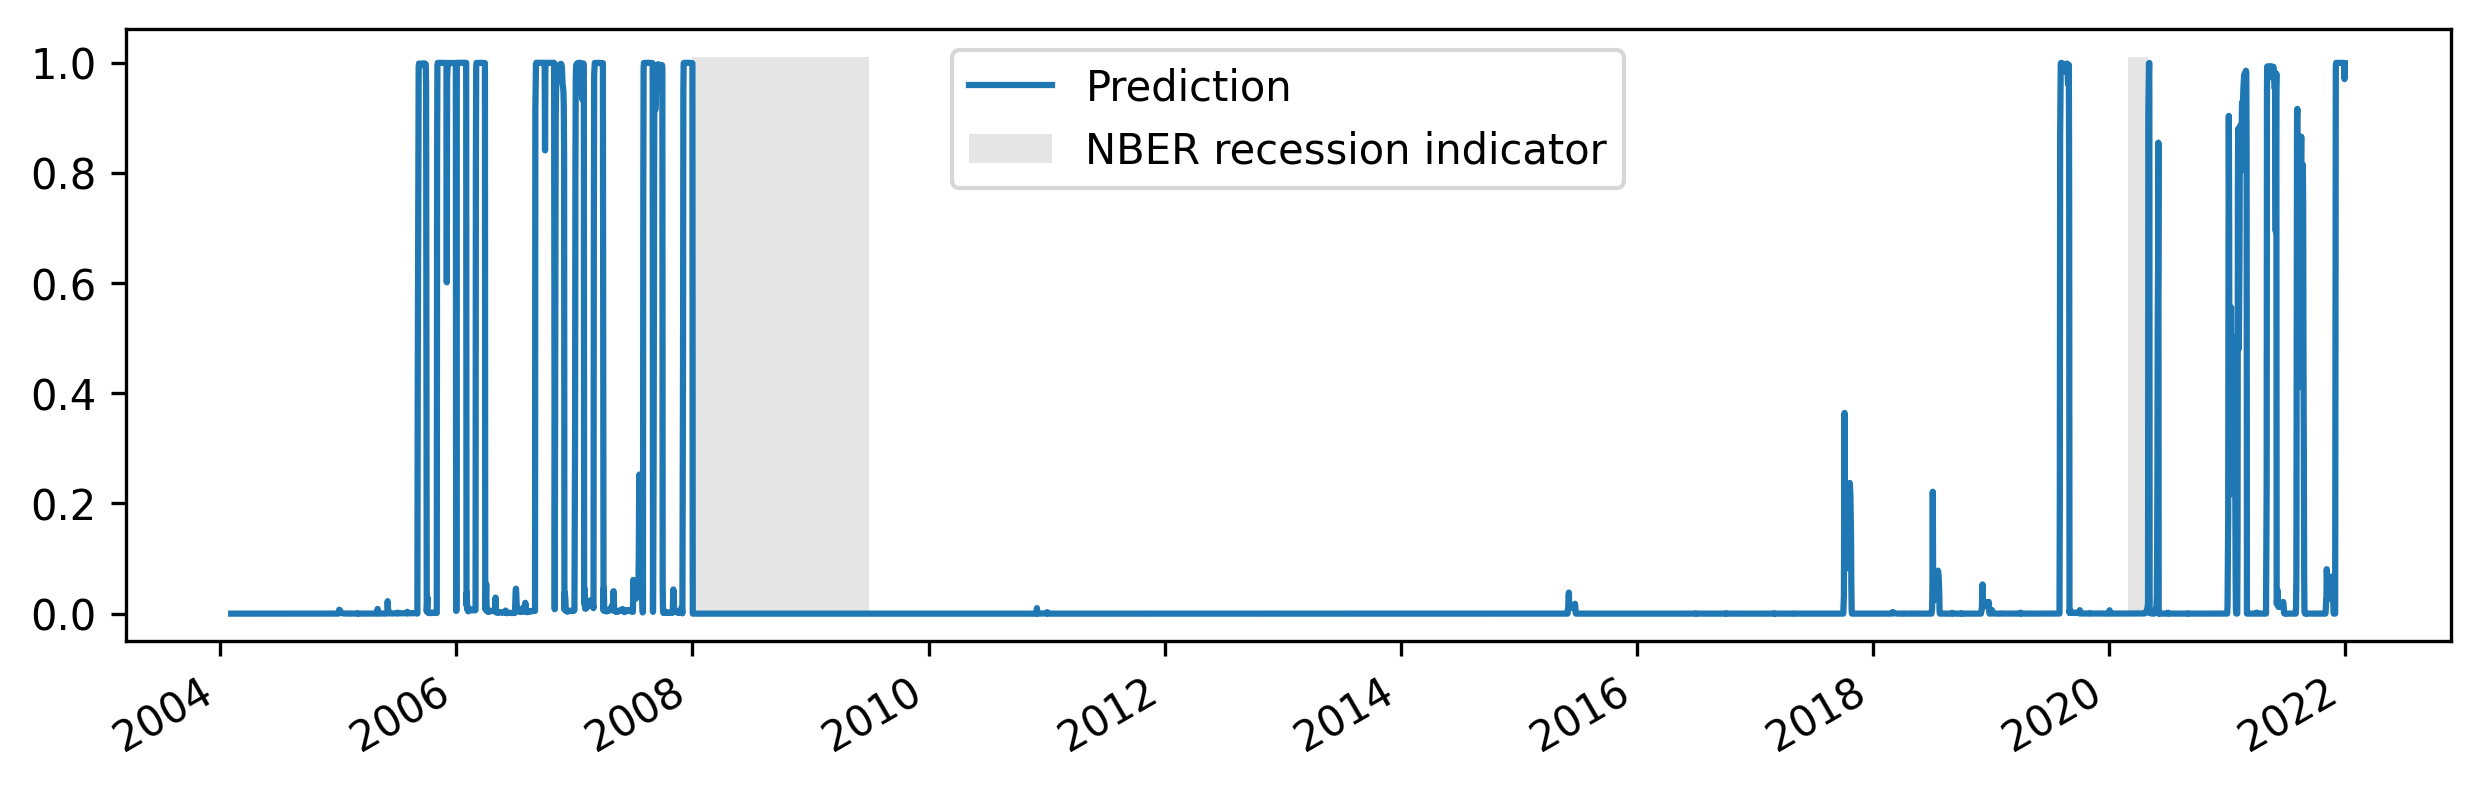

In [86]:

testResults = pd.DataFrame()
testResults['Actual']=df_for_testing.iloc[-prediction.shape[0]:,-2]
testResults["Pred"]=prediction
# testResults=testResults.resample('M').max()
plot(tf.math.sigmoid(testResults['Pred']),testResults["Actual"])